In [15]:
import torch
import numpy as np

In [2]:
# Setup device-agnostic code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

Using device: mps


In [40]:
base_dir = "./processed-data/"
currents = np.load(base_dir + "currents.npz", allow_pickle=True)['currents']
river_heights = np.load(base_dir + "river_heights.npz", allow_pickle=True)['river_heights']
total_coordinates = np.load(base_dir + "total_coordinates.npz", allow_pickle=True)['total_coordinates']


In [20]:
# convert tides to a range of -1 (ebb) to 1 (flood)
river_heights_minmax = 2 * (river_heights - np.min(river_heights)) / (np.max(river_heights) - np.min(river_heights)) - 1
river_heights_minmax.min(), river_heights_minmax.max()

(np.float64(-1.0), np.float64(1.0))

In [49]:
top5_idx = np.argpartition(river_heights_minmax, -5)[-5:]
bottom5_idx = np.argpartition(river_heights_minmax, 5)[:5]

print("Top 5 flood indices and values:"
      , list(zip(top5_idx, river_heights_minmax[top5_idx])))

print("Bottom 5 ebb indices and values:"
        , list(zip(bottom5_idx, river_heights_minmax[bottom5_idx])))

Top 5 flood indices and values: [(np.int64(16549), np.float64(0.968350768215718)), (np.int64(17216), np.float64(0.9781325717370657)), (np.int64(17217), np.float64(1.0)), (np.int64(10425), np.float64(0.992232117516858)), (np.int64(17127), np.float64(0.9988854907236675))]
Bottom 5 ebb indices and values: [(np.int64(537), np.float64(-0.9894743307020992)), (np.int64(9057), np.float64(-0.9949705686555996)), (np.int64(9032), np.float64(-0.9860611618702331)), (np.int64(536), np.float64(-1.0)), (np.int64(487), np.float64(-0.9795734963323472))]


In [60]:
# Let's explore the data to see if river height looks correlated with tides.
# What we're looking for: 
# # Flood: Currents going northwest, high water (positive river_height_minmax)
# # Ebb: Currents going southeast, low water (negative river_height_minmax)

# Indices of the top n flood and bottom n ebb
n = 20
top_idx = np.argpartition(river_heights_minmax, -n)[-n:]
bottom_idx = np.argpartition(river_heights_minmax, n)[:n]


In [ ]:
from plot_utils import plot_surface_currents

print("High River Heights:")
for idx in top_idx:
    print(f"River Height (minmax): {river_heights_minmax[idx]}")
    plot_surface_currents(currents[idx], total_coordinates)

In [ ]:
print("Low River Heights:")
for idx in bottom_idx:
    print(f"River Height (minmax): {river_heights_minmax[idx]}")
    plot_surface_currents(currents[idx], total_coordinates)

In [38]:
min_idx = np.unravel_index(np.nanargmin(currents), currents.shape)
min_value = np.nanmin(currents)

max_idx = np.unravel_index(np.nanargmax(currents), currents.shape)
max_value = np.nanmax(currents)

min_idx, min_value, max_idx, max_value

((np.int64(12956), np.int64(0), np.int64(26), np.int64(48)),
 np.float64(-215.5379535748813),
 (np.int64(13625), np.int64(0), np.int64(26), np.int64(57)),
 np.float64(197.09220833107477))

In [46]:
np.nanargmax(river_heights_minmax), np.nanargmin(river_heights_minmax)

(np.int64(17217), np.int64(536))

In [ ]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset

class CurrentsDataset(Dataset):
    def __init__(self, transform=None):
        self.currents = currents
        self.transform = transform
        self.river_heights_minmax = river_heights_minmax

    def __len__(self):
        return len(self.currents)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.currents[idx]), self.transform(self.river_heights_minmax[idx])

        return self.currents[idx], self.river_heights_minmax[idx]

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.nan_to_num(torch.tensor(x, dtype=torch.float32), nan=0.0)),
])

In [6]:
dataset = CurrentsDataset(transform=transform)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train_dataset = Subset(dataset, range(0, train_size))
test_dataset = Subset(dataset, range(train_size, len(dataset)))

BATCH_SIZE = 64

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False
)


In [7]:
current, label = next(iter(train_loader))
current.shape, label.shape

(torch.Size([64, 2, 74, 93]), torch.Size([64]))

In [ ]:
from functools import partial
import torch.nn as nn

class ResidualUnit(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        DefaultConv2d = partial(nn.Conv2d, kernel_size=3, padding=1, bias=False)
        self.main_layers = nn.Sequential(
            DefaultConv2d(in_channels, out_channels, stride=stride),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            DefaultConv2d(out_channels, out_channels),
            nn.BatchNorm2d(num_features=out_channels),
        )

        if stride > 1:
            # Adjust skip connection to match dimensions
            self.skip_connection = nn.Sequential(
                DefaultConv2d(in_channels, out_channels, kernel_size=1, 
                              stride=stride, padding=0),
                nn.BatchNorm2d(num_features=out_channels)
            )
        else:
            self.skip_connection = nn.Identity()
    
    def forward(self, x):
        return nn.ReLU()(self.main_layers(x) + self.skip_connection(x))
    

class ResNet34(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels=2, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
        ]


In [9]:
import torch
import torch.nn as nn

class ConvRegressor(nn.Module):
    def __init__(self, input_channels=2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, stride=2, padding=1),  # [2,74,93] -> [16,37,47]
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [16,37,47] -> [32,19,24]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # [32,19,24] -> [64,10,12]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.flattened_size = 64 * 10 * 12

        self.regressor = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.regressor(x)
        return x

In [10]:
model = ConvRegressor()
model = model.to(device)
print(next(model.parameters()).device)


mps:0


In [11]:
from torchinfo import summary
summary(model, input_size=(1, 2, 74, 93))

Layer (type:depth-idx)                   Output Shape              Param #
ConvRegressor                            [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 10, 12]           --
│    └─Conv2d: 2-1                       [1, 16, 37, 47]           304
│    └─BatchNorm2d: 2-2                  [1, 16, 37, 47]           32
│    └─LeakyReLU: 2-3                    [1, 16, 37, 47]           --
│    └─Conv2d: 2-4                       [1, 32, 19, 24]           4,640
│    └─BatchNorm2d: 2-5                  [1, 32, 19, 24]           64
│    └─LeakyReLU: 2-6                    [1, 32, 19, 24]           --
│    └─Conv2d: 2-7                       [1, 64, 10, 12]           18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 10, 12]           128
│    └─LeakyReLU: 2-9                    [1, 64, 10, 12]           --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-10                      [1, 256]                  1,966,336

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
)

In [13]:
EPOCHS = 50

model = model.to(device)

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for currents, label in train_loader:
        currents = currents.to(device).float()
        label = label.to(device).float().unsqueeze(1)

        output = model(currents)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * currents.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for currents, labels in test_loader:
            currents = currents.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(currents)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * currents.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    scheduler.step(test_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss:.6f} | "
          f"Test Loss: {test_loss:.6f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

Epoch [1/50] | Train Loss: 0.019657 | Test Loss: 0.016837 | LR: 0.001000
Epoch [2/50] | Train Loss: 0.014081 | Test Loss: 0.015754 | LR: 0.001000
Epoch [3/50] | Train Loss: 0.012310 | Test Loss: 0.013285 | LR: 0.001000
Epoch [4/50] | Train Loss: 0.010750 | Test Loss: 0.013555 | LR: 0.001000
Epoch [5/50] | Train Loss: 0.009903 | Test Loss: 0.012017 | LR: 0.001000
Epoch [6/50] | Train Loss: 0.009649 | Test Loss: 0.012007 | LR: 0.001000
Epoch [7/50] | Train Loss: 0.008423 | Test Loss: 0.011566 | LR: 0.001000
Epoch [8/50] | Train Loss: 0.007090 | Test Loss: 0.011535 | LR: 0.001000
Epoch [9/50] | Train Loss: 0.006662 | Test Loss: 0.011811 | LR: 0.001000
Epoch [10/50] | Train Loss: 0.005630 | Test Loss: 0.012301 | LR: 0.001000
Epoch [11/50] | Train Loss: 0.004637 | Test Loss: 0.011396 | LR: 0.001000
Epoch [12/50] | Train Loss: 0.004086 | Test Loss: 0.010775 | LR: 0.001000
Epoch [13/50] | Train Loss: 0.004046 | Test Loss: 0.011235 | LR: 0.001000
Epoch [14/50] | Train Loss: 0.004211 | Test Los

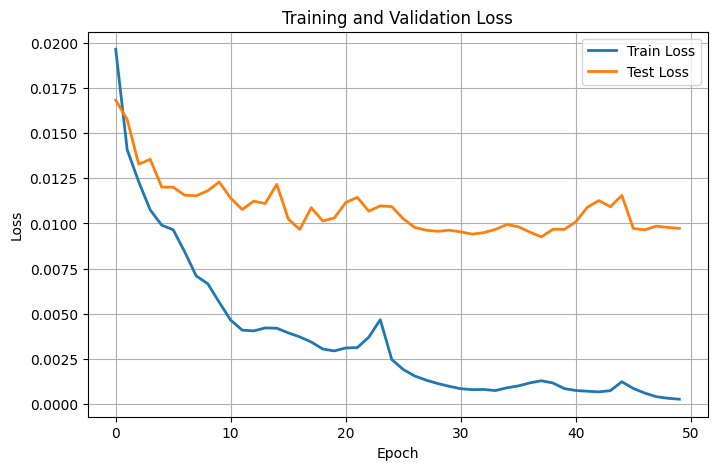

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()